<a href="https://colab.research.google.com/github/vokashlob/OTUS/blob/main/OTUS_torch_practice_homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Создать и обучить регрессионную модель, которая аппроксимирует значение 
функции sin(x + 2*y)*exp(-(2*x + y)^2) на диапазоне значений [-10;10] по х и у.
2. В качестве обучающей выборки необходимо сгенерировать 20000 точек случайным образом.
3. Разделить получившийся датасет на train / test / val в отношениях 70% / 15% / 15%, соответственно.

In [ ]:
import numpy as np
import math
import torch
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
%matplotlib inline

In [ ]:
data = 20*np.random.rand(20000,3)-10
x = data[:,0]
y = data[:,1]
data[:,2] = np.sin(x + 2*y)*np.exp(-(2*x + y)**2)
data.shape

(20000, 3)

In [ ]:
print(data[:,2].min(), data[:,2].max())

-0.9897272110291656 0.9974830861474001


In [ ]:
z = data[:,2]

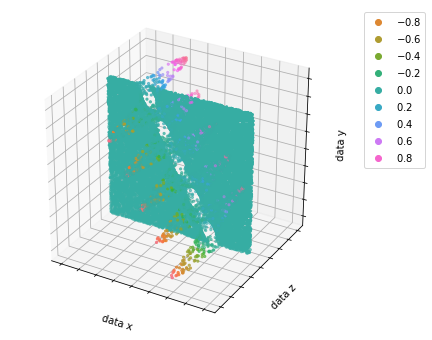

In [ ]:
cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(x, z, y, s=5, c=z, cmap=cmap)
ax.set_xlabel('data x')
ax.set_ylabel('data z')
ax.set_zlabel('data y')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
plt.show();

<Figure size 432x288 with 0 Axes>

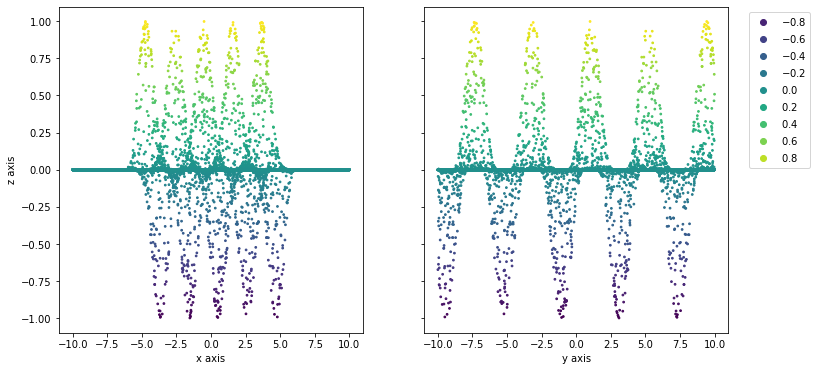

In [ ]:
plt.clf();
fig = plt.figure(figsize=(12,6));
ax=fig.add_subplot(121);
plt.scatter(x, z, c=z, s=3);
plt.xlabel('x axis');
plt.ylabel('z axis');
ax=fig.add_subplot(122);
sc = ax.scatter(y, z, c=z, s=3);
plt.xlabel('y axis');
ax.set_yticklabels([]);
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
plt.show();

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data[:, :2], z, test_size=.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=.5, random_state=42)
print(y_train.shape, y_test.shape, y_val.shape)

(14000,) (3000,) (3000,)


## Низкоуровневый вариант (вне задания, для себя)

In [ ]:
X_tensor = torch.from_numpy(X_train).float()
y_tensor = torch.from_numpy(y_train).float()
y_tensor.shape

torch.Size([14000])

In [ ]:
def lin_reg_model(X, w, b):
    return torch.matmul(X, w.T) + b

In [ ]:
def mse(true, predicted):
    return ((true - predicted) ** 2).sum() / true.numel()

In [ ]:
# по мотивами Kaiming initialization
weight = torch.randn(y_tensor.shape[0], X_tensor.shape[1]) / math.sqrt(2 / y_tensor.shape[0])
bias = torch.zeros(y_tensor.shape[0])
# начинаем записывать историю вычислений
weight.requires_grad_(True)
bias.requires_grad_(True);

In [ ]:
learning_rate = 1
epochs = 10000

for epoch in range(epochs):
    # forward pass — вычисляем функцию потерь
    predictions = lin_reg_model(X_tensor.to('cuda'), weight.to('cuda'), bias.to('cuda'))
    loss = mse(predictions, y_tensor.to('cuda'))
    # backward paass — вычисляем градиент
    loss.backward()
    # вычитаем производные из параметров
    # записывать историю вычислений уже не нужно (no_grad)
    with torch.no_grad():
        weight -= weight.grad * learning_rate
        bias -= bias.grad * learning_rate
        # обнуляем производные
        weight.grad.zero_()
        bias.grad.zero_()
    # выводим значение фукнции потерь каждые 2000 повторов
    if (epoch + 1) % 100 == 0:
      print('epoch {}, loss {}'.format(epoch + 1, loss.item()))

epoch 100, loss 14.136964797973633
epoch 200, loss 5.508139133453369
epoch 300, loss 2.154475450515747
epoch 400, loss 0.8506031632423401
epoch 500, loss 0.3433662950992584
epoch 600, loss 0.1457935869693756
epoch 700, loss 0.06861793994903564
epoch 800, loss 0.0382661297917366
epoch 900, loss 0.026133352890610695
epoch 1000, loss 0.021096210926771164
epoch 1100, loss 0.01882835477590561
epoch 1200, loss 0.017646657302975655
epoch 1300, loss 0.016896063461899757
epoch 1400, loss 0.016321444883942604
epoch 1500, loss 0.015823284164071083
epoch 1600, loss 0.01536262221634388
epoch 1700, loss 0.014924071729183197
epoch 1800, loss 0.014501433819532394
epoch 1900, loss 0.01409208495169878
epoch 2000, loss 0.013694808818399906
epoch 2100, loss 0.013308932073414326
epoch 2200, loss 0.012934005819261074
epoch 2300, loss 0.012569671496748924
epoch 2400, loss 0.012215612456202507
epoch 2500, loss 0.011871530674397945
epoch 2600, loss 0.011537143029272556
epoch 2700, loss 0.011212176643311977
epo

## Вариант на фреймворке